In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import KNNImputer

from datassist import explore
from datassist import examine_results
from datassist import log_results

In [2]:
df_titanic = pd.read_csv('data/train.csv')

In [3]:
df_titanic = df_titanic.set_index('PassengerId')

In [4]:
explore.overview(df_titanic)

,NULL Count,NULL %,Unique Items,Type
Survived,0,0.0,2,int64
Pclass,0,0.0,3,int64
Name,0,0.0,891,object
Sex,0,0.0,2,object
Age,177,19.9,88,float64
SibSp,0,0.0,7,int64
Parch,0,0.0,7,int64
Ticket,0,0.0,681,object
Fare,0,0.0,248,float64
Cabin,687,77.1,147,object


In [5]:
explore.count_group(df_titanic, ['Embarked'])

,Embarked,Count
0,C,168
1,Q,77
2,S,644


**Preprocess Data**

In [6]:
null_rows = explore.find_null_rows(df_titanic, columns=['Embarked'])
null_rows

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
# preprocess the data
X_train = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket', 'Embarked'])
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())

# Split out into train set and values we want to impute
X_test = X_train.iloc[null_rows.index]
X_train = X_train.drop(null_rows.index)


In [8]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,0,22.0,1,0,7.2500
2,1,1,38.0,1,0,71.2833
3,3,1,26.0,0,0,7.9250
4,1,1,35.0,1,0,53.1000
5,3,0,35.0,0,0,8.0500


In [9]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
63,1,0,45.0,1,0,83.4750
831,3,1,15.0,1,0,14.4542


In [10]:
name2label = {'S': 0, 'C': 1, 'Q': 2}
label2name = {v: k for k, v in name2label.items()}

y_train = df_titanic['Embarked'].dropna()\
    .map(name2label).astype(int)
y_train.head()

PassengerId
1    0
2    1
3    0
4    0
5    0
Name: Embarked, dtype: int32

**Impute missing "Embarked" values using RandomForest**

In [11]:
RANDOM_STATE = 42

clf = RandomForestClassifier(random_state=RANDOM_STATE)

n_items = 20
max_depth_dist = list(np.logspace(1, 3, n_items, endpoint=True).astype(int))
max_depth_dist.append(None)
param_distributions = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': np.logspace(1, 3, n_items, endpoint=True).astype(int),
    'max_depth': max_depth_dist,
}

rand_search = RandomizedSearchCV(
    clf, param_distributions, random_state=RANDOM_STATE, n_jobs=-1, n_iter=100
)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 12, 16, 20, 26, 33,
                                                      42, 54, 69, 88, 112, 143,
                                                      183, 233, 297, 379, 483,
                                                      615, 784, 1000, None],
                                        'n_estimators': array([  10,   12,   16,   20,   26,   33,   42,   54,   69,   88,  112,
        143,  183,  233,  297,  379,  483,  615,  784, 1000])},
                   random_state=42)

In [12]:
print(f'Best Params:')
for p, v in rand_search.best_params_.items():
    print(f'\t{p}: {v}')
print(f'Score:\n\t{rand_search.best_score_:.3f}')

Best Params:
	n_estimators: 54
	max_depth: 10
	criterion: log_loss
Score:
	0.834


In [13]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [14]:
examine_results.feature_importance(
    rand_search.best_estimator_,
    feature_names=X_train.columns
)

,Feature,Importance
0,Fare,0.508774
1,Age,0.233437
2,Pclass,0.102203
3,SibSp,0.065257
4,Parch,0.049062
5,Sex,0.041268


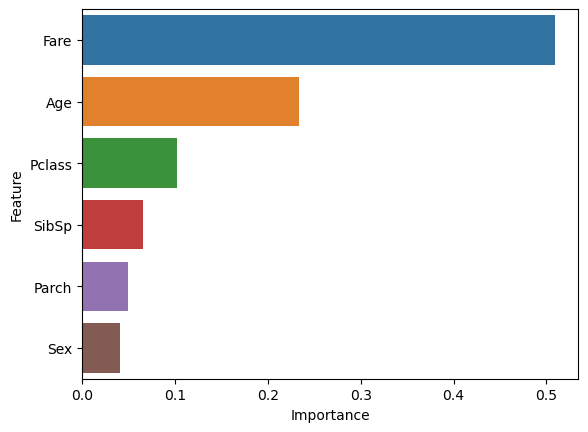

In [25]:
examine_results.plot_feature_importances(
    rand_search.best_estimator_,
    feature_names=X_train.columns
)

In [16]:
y_pred = rand_search.best_estimator_.predict(X_test)
pd.DataFrame(
    data={'Embarked': [label2name[l] for l in y_pred]},
    index=null_rows.index
)

,Embarked
PassengerId,
62,S
830,C


In [17]:
proba = rand_search.best_estimator_.predict_proba(X_test)
# put into dataframe with class labels
y_classes = [label2name[i] for i in rand_search.best_estimator_.classes_]
df_proba = pd.DataFrame(data=proba, columns=y_classes, index=null_rows.index)
df_proba

,S,C,Q
PassengerId,,,
62,0.776630,0.216355,0.007015
830,0.076477,0.909737,0.013786


<Axes: >

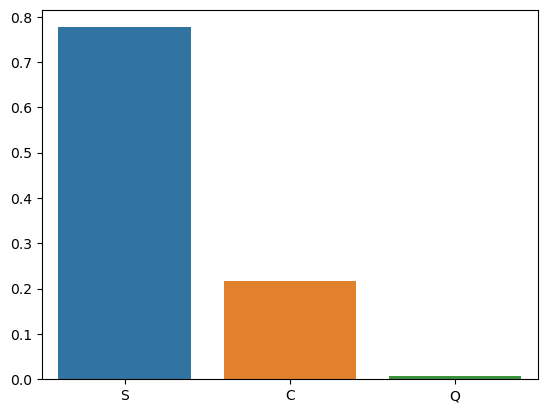

In [18]:
sns.barplot(df_proba[(df_proba.index == 62)])

<Axes: >

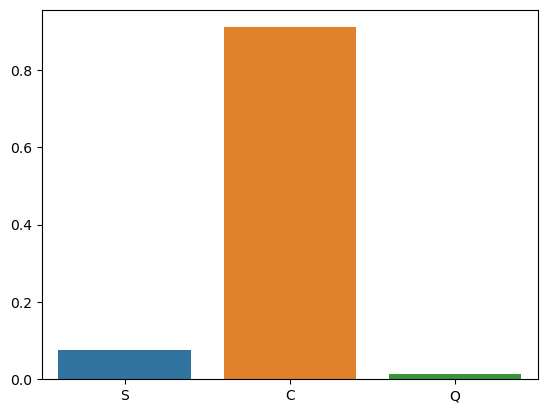

In [19]:

sns.barplot(df_proba[(df_proba.index == 830)])

In [20]:
helper = log_results.MlflowHelper()
helper.start_local_tracking_server()
helper.setup_experiment('EmbarkedImpute')

In [21]:
def log_results(model, params, metrics, tags):
    return model, params, metrics, tags

In [22]:
params = rand_search.best_params_
params['random_state'] = RANDOM_STATE

metrics = {'Score': rand_search.best_score_}

tags = {'Prediction': f'{label2name[y_pred[0]]}{label2name[y_pred[1]]}'}

helper.run_experiment(
    lambda: log_results(rand_search.best_estimator_, params, metrics, tags)
)

fluent 2


c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


**Impute missing values using KNN Imputer**

In [23]:
imputer = KNNImputer(n_neighbors=3)
X_knn = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket'])
X_knn['Sex'] = X_knn['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_knn['Age'] = X_knn['Age'].fillna(X_knn['Age'].median())
X_knn['Embarked'] = X_knn['Embarked'].fillna('U').map(name2label)
X_imputed = imputer.fit_transform(X_knn)
X_imputed = pd.DataFrame(
    data=X_imputed,
    columns=X_knn.columns,
    index=X_knn.index
)
X_imputed.loc[null_rows.index]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
62,1.0,1.0,38.0,0.0,0.0,80.0,0.333333
830,1.0,1.0,62.0,0.0,0.0,80.0,0.666667


KNNImputer doesn't seem to produce integer values, and I'm not sure how to interpret the results.